## 6.3 순환 신경망의 고급 사용법

### 6.3.1 기온 예측 문제

### 코드 6-28 예나 날씨 데이터셋 조사

In [2]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print (header)
print (len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### 코드 6-29 데이터 파싱

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values # 이 구문 이해 안됨
    

### 코드 6-30 시계열 온도 그래프 그리기

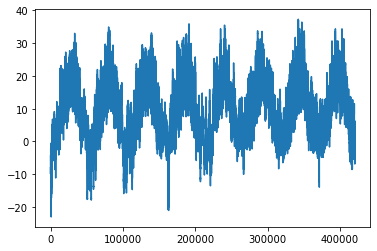

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # 온도(섭씨)
plt.plot(range(len(temp)), temp, label='Whole period c')

### 코드 6-31 처음 10일간 온도 그래프 그리기

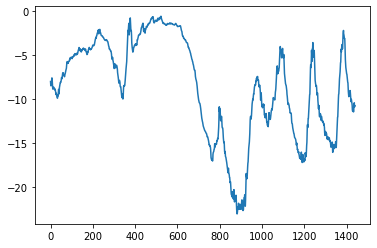

In [5]:
plt.plot(range(1440), temp[:1440])

### 코드 6-32 데이터 정규화

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

### 코드 6-33 시계열 데이터와 타겟을 반환하는 제너레이터 함수

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


### 코드 6-34 훈련, 검증, 테스트 제너레이터 준비

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step,
                   batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # 전체 Validation Sets을 순회하기 위해 val_gen에서 추출할 횟수

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 코드 6-35 상식적 기준 모델의 MAE 계산

In [9]:
def evaluate_naive_method():
    batch_maes = list()
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


### 코드 6-36 MAE를 섭씨 단위로 변환

In [10]:
celsius_mae = 0.29 * std[1]

### 코드 6-37 완전 연결 모델을 훈련하고 평가

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 7s 15ms/step - loss: 1.2273 - val_loss: 0.5404
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.4030 - val_loss: 0.3210
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2904 - val_loss: 0.3412
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2691 - val_loss: 0.3023
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2534 - val_loss: 0.3124
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2443 - val_loss: 0.3210
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2365 - val_loss: 0.3119
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2308 - val_loss: 0.3537
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2264 - val_loss: 0.3674
Epoch 10/20
500

###  코드 6-38 결과 그래프 그리기

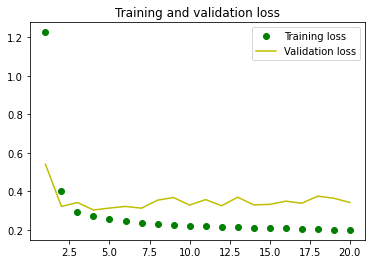

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 코드 6-39 GRU를 사용한 모델을 훈련하고 평가

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3051 - val_loss: 0.2696
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2840 - val_loss: 0.2661
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2774 - val_loss: 0.2692
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2728 - val_loss: 0.2636
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2689 - val_loss: 0.2659
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2624 - val_loss: 0.2656
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2597 - val_loss: 0.2654
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2520 - val_loss: 0.2728
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2491 - val_loss: 0.2697
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.244

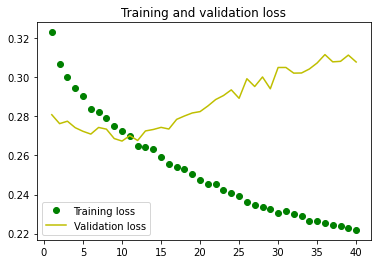

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 코드 6-40 드롭아웃 규제된 GRU를 사용한 모델을 훈련 및 평가

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 357s 714ms/step - loss: 0.3230 - val_loss: 0.2808
Epoch 2/40
500/500 [==============================] - 238s 477ms/step - loss: 0.3066 - val_loss: 0.2763
Epoch 3/40
500/500 [==============================] - 243s 486ms/step - loss: 0.2999 - val_loss: 0.2775
Epoch 4/40
500/500 [==============================] - 242s 484ms/step - loss: 0.2945 - val_loss: 0.2742
Epoch 5/40
500/500 [==============================] - 251s 501ms/step - loss: 0.2903 - val_loss: 0.2723
Epoch 6/40
500/500 [==============================] - 252s 504ms/step - loss: 0.2838 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 342s 684ms/step - loss: 0.2822 - val_loss: 0.2743
Epoch 8/40
500/500 [==============================] - 240s 479ms/step - loss: 0.2790 - val_loss: 0.2734
Epoch 9/40
500/500 [==============================] - 240s 481ms/step - loss: 0.2752 - val_loss: 0.2686
Epoch 10/40
500/500 [==============================] - 239s 478m

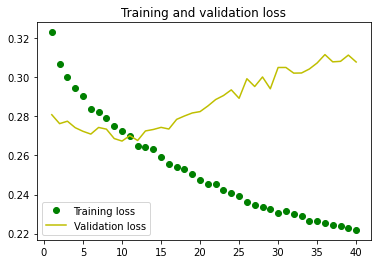

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

model.svae('gru_model_with_dropout.h5')

Epoch 1/40
500/500 [==============================] - 434s 868ms/step - loss: 0.3239 - val_loss: 0.2797
Epoch 2/40
500/500 [==============================] - 470s 939ms/step - loss: 0.3052 - val_loss: 0.2702
Epoch 3/40
500/500 [==============================] - 472s 943ms/step - loss: 0.2997 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 468s 936ms/step - loss: 0.2935 - val_loss: 0.2835
Epoch 5/40
500/500 [==============================] - 431s 862ms/step - loss: 0.2888 - val_loss: 0.2712
Epoch 6/40
500/500 [==============================] - 271s 543ms/step - loss: 0.2868 - val_loss: 0.2710
Epoch 7/40
500/500 [==============================] - 269s 538ms/step - loss: 0.2833 - val_loss: 0.2723
Epoch 8/40
500/500 [==============================] - 262s 523ms/step - loss: 0.2804 - val_loss: 0.2708
Epoch 9/40
500/500 [==============================] - 263s 526ms/step - loss: 0.2748 - val_loss: 0.2749
Epoch 10/40
500/500 [==============================] - 265s 531m

AttributeError: 'Sequential' object has no attribute 'svae'